In [21]:
# Import packages
# from preprocessing.filtering import Preprocess
# from preprocessing.fiducials import FpCollection
# from preprocessing import PPG

# from preprocessing import Fiducials, Biomarkers
# import pyPPG.biomarkers as BM

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler, LabelEncoder
# from pathlib import Path
# from dotmap import DotMap
# import numpy as np
# import pandas as pd
# import scipy.io
# import random
# import os
# import h5py



In [1]:
# Import packages
from utils.dataloaders import Crops
from utils import random_state
import random

random_state(36)

In [2]:
# dataset
crops_data = Crops()
crops_data.split(test_size=0.15)

# test_set = CropsDataset(crops_data.test, mode=mode, stratify=False)
# val_set = CropsDataset(crops_data.val, mode=mode, stratify=True)
# train_set = CropsDataset(crops_data.train, mode=mode, stratify=True)

loading N_crops.h5...
loading V_crops.h5...
loading S_crops.h5...


In [3]:
# Parameters
stratify = True

# Stratify
V = []
S = []
N = []
for x, y in crops_data.train:
    if y == "V" :
        V.append(x)
    elif y == "S":
        S.append(x)
    else:
        N.append(x)

n_smallest_class = min(len(V), len(S))
dataset = {label: crops for label, crops in zip(['N', 'V', 'S'], [N, V, S])}

# Stratify the dataset
if stratify:
    random.seed(36)
    for label, crops in dataset.items():
        if len(crops) > n_smallest_class:
            random.shuffle(crops)
            if label == 'N':
                dataset[label] = crops[0:2*n_smallest_class]

            elif label in ['V', 'S']:
                dataset[label] = crops[0:n_smallest_class]

for label, crops in dataset.items():
    print(f'{label}: {len(crops)}')

print(f'Total number of crops for training: {sum([len(crops) for crops in dataset.values()])} / {4*n_smallest_class}')

N: 11192
V: 5596
S: 5596
Total number of crops for training: 22384 / 22384


In [4]:
# Parameters
stratify = True

data = {}
for split_name, split_data in zip(["train", "val", "test"], [crops_data.train, crops_data.val, crops_data.test]):

    # Stratify
    V = []
    S = []
    N = []
    for crop, label in split_data:
        if label == "V" :
            V.append(crop)
        elif label == "S":
            S.append(crop)
        else:
            N.append(crop)

    n_smallest_class = min(len(V), len(S))
    dataset = {label: crops for label, crops in zip(['N', 'V', 'S'], [N, V, S])}
    
    # Stratify the dataset
    if split_name in ["train", "val"]:
        if stratify:
            random.seed(36)
            for label, crops in dataset.items():
                if len(crops) > n_smallest_class:
                    random.shuffle(crops)
                    if label == 'N':
                        dataset[label] = crops[0:2*n_smallest_class]

                    elif label in ['V', 'S']:
                        dataset[label] = crops[0:n_smallest_class]

    data[split_name] = dataset

    print(f'{split_name} dataset:')
    for label, crops in dataset.items():
        print(f'{label}: {len(crops)}')
    print('-'*20)



print(f'Total number of crops for training: {sum([len(crops) for crops in data["train"].values()])}')

train dataset:
N: 11192
V: 5596
S: 5596
--------------------
val dataset:
N: 2398
V: 1199
S: 1199
--------------------
test dataset:
N: 34056
V: 1199
S: 1454
--------------------
Total number of crops for training: 22384


In [32]:
len(data['train']['N'])

data_train_N = data['train']['N']
data_train_V = data['train']['V']
data_train_S = data['train']['S']

data_test_N = data['val']['N']
data_test_S = data['val']['S']
data_test_V = data['val']['V']

In [6]:
import matplotlib.pyplot as plt
import numpy as np

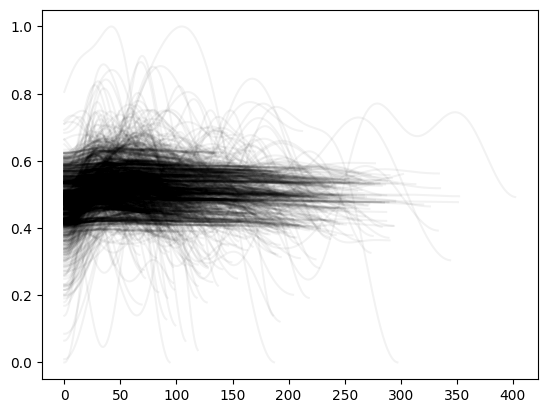

In [28]:
for i in range(2000):
    plt.plot(data_train_N[i], 'k', alpha=0.05)

plt.show()

In [9]:
max_len = np.max([len(crop) for crop in data_train_N])
n = len(data_train_N)
max_ampl = [np.max(np.abs(crop)) for crop in data_train_N]

avg = np.zeros(max_len)

for crop, maxim in zip(data_train_N, max_ampl):
    n_crop = len(crop)
    avg[:n_crop] += crop/n/maxim

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
# a = np.array(data_train_S)
max_ampl = [np.max(np.abs(crop)) for crop in data_train_N]

print(max_ampl)

for i in range(2000):
    if max_ampl[i] < 80:
        plt.plot(data_train_N[i]/max_ampl[i], 'k', alpha=0.05)
    else:
        plt.plot(data_train_N[i]/max_ampl[i], 'b', alpha=0.5)

plt.plot(avg, 'r')

plt.show()

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
plt.hist(max_ampl, bins=5000)
plt.show()

NameError: name 'max_ampl' is not defined

In [ ]:
np.sort(max_ampl)[-50:]

NameError: name 'max_ampl' is not defined

EXTRACTING FEATURES FROM CROPS AND WRITING TO CSV

In [246]:
import numpy as np

from scipy import stats


print('Number of N crops: ',len(data_train_N))
test_crop = data_train_N[11]
print('Length of test crop: ', len(test_crop))


Number of N crops:  11192
Length of test crop:  90


*DEFINING FUNCTIONS FOR EXTRACTING FEATURES*

In [261]:
import pandas as pd

def find_nearest(array, value): #From https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array, used for one of features
    array = np.asarray(array)
    if len(array) == 0:
        idx = 0
    else:
        idx = (np.abs(array - value)).argmin()
    return idx

def get_pulse_width(crop):  #need to verify if this done correctly...

    half_peak = max(crop)/2
    idx_peak = np.argmax(crop[1:])
    idx_t1 = find_nearest(crop[:idx_peak], half_peak) #number of timesteps for amplitude to get to half value of peak before peak
    idx_t1 = len(crop[:idx_peak]) -idx_t1 #time from that point to peak
    idx_t2 = find_nearest(crop[idx_peak:], half_peak) #number of timesteps for amplitude to get to half value of peak after peak

    return idx_t2+idx_t1 #time between half maximum values
    
def drop_empty_crops(crops):

    out = [crop for crop in crops if len(crop) > 4]
    print("Number of crops eliminated: ", len(crops)-len(out))
    return out

def get_max_freq(crop, fs): #NEED FS OF INDIVIDUAL SIGNAL :(
    fft = np.fft.fft(crop)
    freqs = np.fft.fftfreq(len(crop), d=1/fs)
    dom_freq_idx = np.argmax(np.abs(fft))
    dom_freq = np.abs(freqs[dom_freq_idx])
    
    return dom_freq

def get_symmetry_index(crop): #
    middle_idx = len(crop) // 2
    
    left_half = crop[:middle_idx]
    right_half = crop[middle_idx:]
    

    mean_left = np.mean(left_half)
    mean_right = np.mean(right_half)

    symmetry_index = mean_right / mean_left
    
    return symmetry_index


def crops2features(crops):

    list_of_features = ['mean', 'median', 'std', 'var', 'skew', 'kurt','auc','peak_amplitude','pulse_width','max_freq','symmetry', 'peak_position']

    ind = 0
    df = pd.DataFrame(columns = list_of_features)
    for crop in crops:

        #First 6 features taken from Lab 1, rest inspired by ChatGPT
        values = [np.mean(crop),
                  np.median(crop),
                  np.std(crop),
                  stats.tvar(crop),
                  stats.skew(crop),
                  stats.kurtosis(crop),

                    sum(np.array(crop)-min(crop)), #not sure if sound, since min could also be before or after crop...
                    max(crop)-min(crop), #idem
                    get_pulse_width(crop),
                    get_max_freq(crop, 128), #assumed 128 for now....
                    get_symmetry_index(crop),
                    int(np.argmax(crop))
                  ]

        df2 = pd.DataFrame(dict(zip(list_of_features,
                                    values)), index = [ind])
        df = pd.concat([df,df2])
        ind += 1

    return df


Dropping empty crops (Not ideal, but otherwise no feature extraction possible for too short crops... Very minimal amount of empty ones though so if we just label those 'N' by default it's not gonna influence our accuracy in a noticeable way at all: of over 11000 'N' crops, only 7 were dropped, so not even 0.1%....)

In [295]:
data_train_N_emptydropped = drop_empty_crops(data_train_N)
data_train_S_emptydropped = drop_empty_crops(data_train_S)
data_train_V_emptydropped = drop_empty_crops(data_train_V)

data_test_N_emptydropped = drop_empty_crops(data_test_N)
data_test_S_emptydropped = drop_empty_crops(data_test_S)
data_test_V_emptydropped = drop_empty_crops(data_test_V)





Number of crops eliminated:  7
Number of crops eliminated:  3
Number of crops eliminated:  0
Number of crops eliminated:  0
Number of crops eliminated:  1
Number of crops eliminated:  1


*CONVERTING THE TRAIN AND TEST DATA TO DATAFRAMES OF FEATURES*

In [296]:
N_features_train = crops2features(data_train_N_emptydropped)

In [297]:
S_features_train = crops2features(data_train_S_emptydropped)
V_features_train = crops2features(data_train_V_emptydropped)

In [273]:
N_features_test = crops2features(data_test_N_emptydropped)

In [274]:
S_features_test = crops2features(data_test_S_emptydropped)
V_features_test = crops2features(data_test_V_emptydropped)

In [298]:
print(len(N_features_test), len(N_features_train), len(S_features_test),len(S_features_train),len(V_features_test),len(V_features_train))

2398 11185 1198 5593 1198 5596


See if dataframes look like what we want:

In [301]:
N_features_train = N_features_train.dropna()
N_features_test = N_features_test.dropna()

S_features_train = S_features_train.dropna()
S_features_test = S_features_test.dropna()

V_features_train = V_features_train.dropna()
V_features_test = V_features_test.dropna()

print(len(N_features_test), len(N_features_train), len(S_features_test),len(S_features_train),len(V_features_test),len(V_features_train))


2398 11185 1198 5593 1198 5596


Making a full training and testing set from all the computed dataframes:

In [311]:
train_labels = [1 for i in range(len(N_features_train))] + [0 for i in range(len(S_features_train))] + [0 for i in range(len(V_features_train))] 
test_labels = [1 for i in range(len(N_features_test))] + [0 for i in range(len(S_features_test))] + [0 for i in range(len(V_features_test))] 



train_set= pd.concat([N_features_train,S_features_train,V_features_train])
test_set = pd.concat([N_features_test,S_features_test,V_features_test])

print(len(train_labels),len(train_set),len(test_labels),len(test_set))




22374 22374 4794 4794
22374 22374 4794 4794


SHUFFLE

In [312]:
from sklearn.model_selection import train_test_split
train_set, _, train_labels, _ = train_test_split(train_set, train_labels, test_size=0.00001, random_state=42) #we already have a test set... using this for shuffling

Fitting the data to a default Random Forest Classifier and others (skip to last confusion matrix, lots of repeated code)

Accuracy: 0.8128911138923655


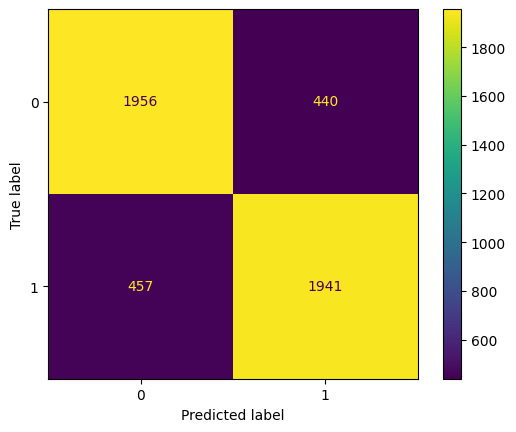

In [321]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(train_set, train_labels)
pred_labels = model.predict(test_set)

from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labels, pred_labels))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


Note: when testing on test set instead of val set, prediction becomes really bad....Also why is test set so large?

Accuracy: 0.523153942428035


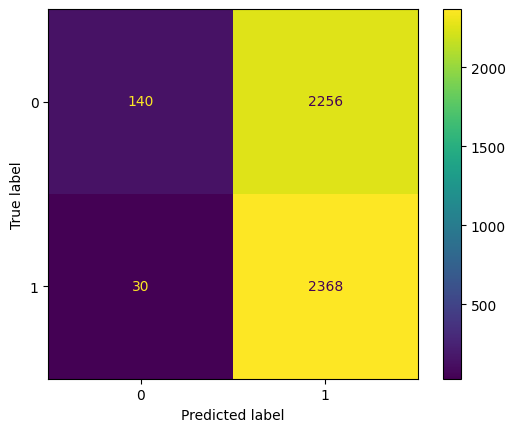

In [322]:
from sklearn.svm import LinearSVC
model = LinearSVC()
model.fit(train_set, train_labels)
pred_labels = model.predict(test_set)

from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labels, pred_labels))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


Interesting note: when trying svm different times, it almost always either predicts everything as 1 OR everything as 0

In [323]:
from xgboost import XGBClassifier
model = XGBClassifier()

In [324]:
pulsewidth_train = train_set['pulse_width']
pulsewidth_test = test_set['pulse_width']

pulsewidth_test = pulsewidth_test.astype(int)
pulsewidth_test.head()

pulsewidth_train = pulsewidth_test.astype(int)
pulsewidth_test.head()

0    82
1    74
2    80
3    95
4    65
Name: pulse_width, dtype: int32

Accuracy: 0.811639549436796


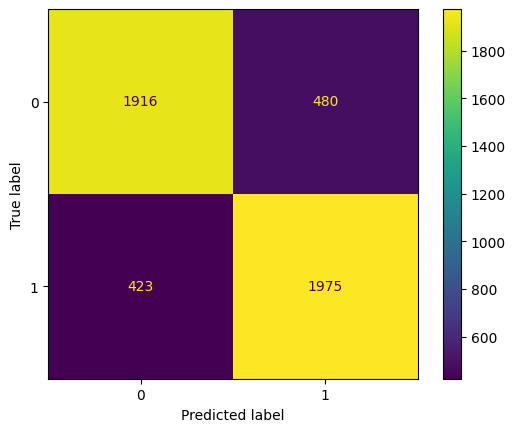

In [325]:

train_setXGB, test_setXGB = train_set.__deepcopy__(), test_set.__deepcopy__()
train_setXGB[['pulse_width','peak_position']], test_setXGB[['pulse_width','peak_position']] = train_set[['pulse_width','peak_position']].astype(int), test_set[['pulse_width','peak_position']].astype(int)
model.fit(train_setXGB, train_labels)
pred_labels = model.predict(test_setXGB)

from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labels, pred_labels))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

[LightGBM] [Info] Number of positive: 11184, number of negative: 11189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3022
[LightGBM] [Info] Number of data points in the train set: 22373, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499888 -> initscore=-0.000447
[LightGBM] [Info] Start training from score -0.000447
Accuracy: 0.8078848560700876


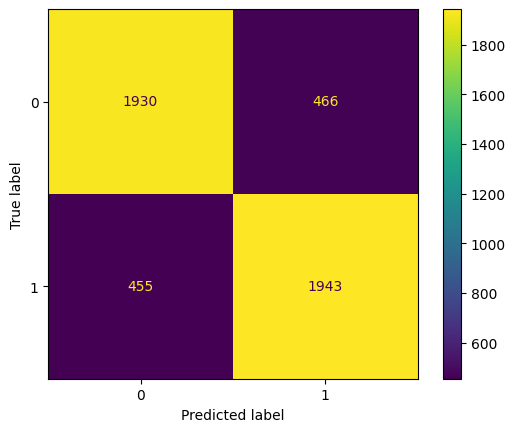

In [326]:
from lightgbm import LGBMClassifier
model = LGBMClassifier()
model.fit(train_setXGB, train_labels)
pred_labels = model.predict(test_setXGB)

from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labels, pred_labels))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Accuracy: 0.6992073425114727


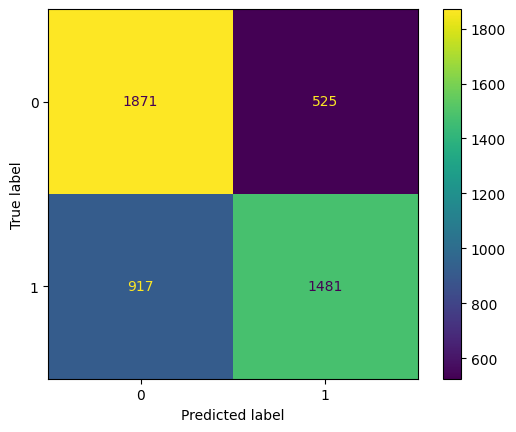

In [166]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(train_set, train_labels)
pred_labels = model.predict(test_set)

from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labels, pred_labels))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


BOTTOM LINE: At first glance, RFC and XGBoost seem to perform well.

*DROPPING FEATURES THAT ARE TOO CORRELATED*

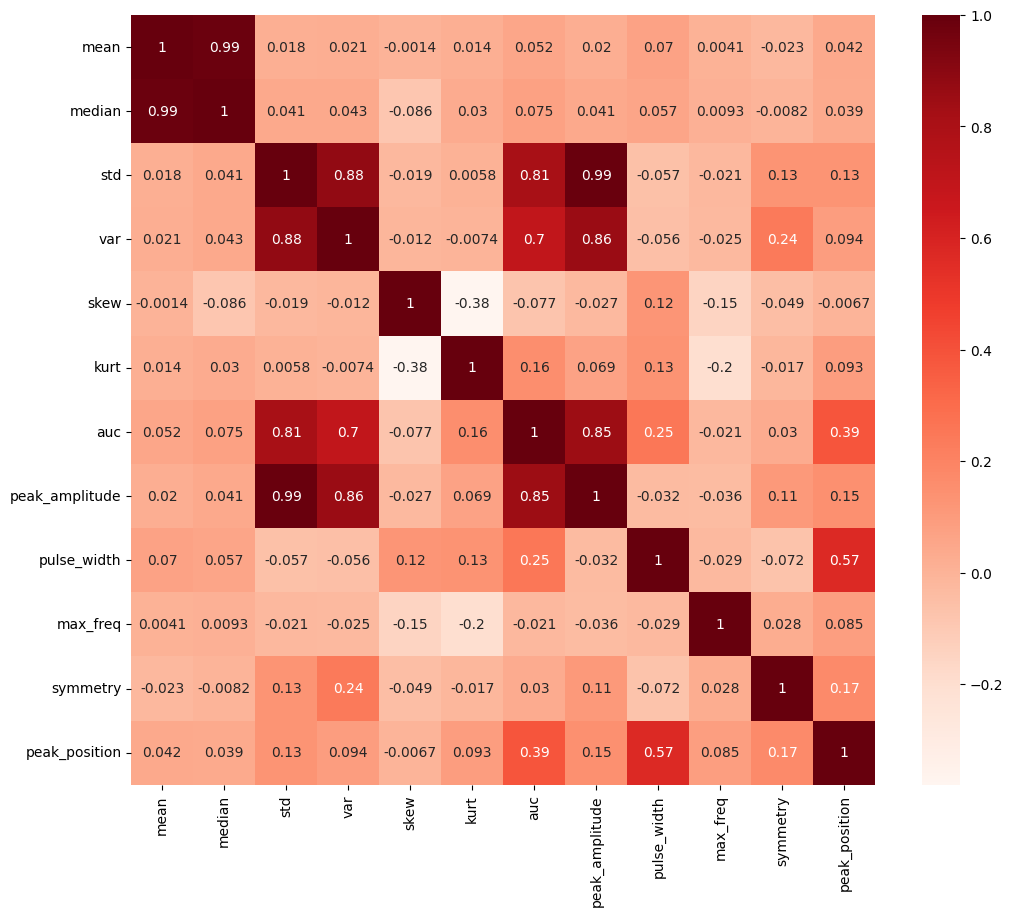

In [327]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
cor = train_set.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [328]:
correlated_features = set()
correlation_matrix = train_set.corr()
median_corr = (correlation_matrix.abs()).median(axis=0)

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8: ##################################################
            if median_corr[i] < median_corr[j]:
                colname = correlation_matrix.columns[i]
            else:
                colname = correlation_matrix.columns[j]
            correlated_features.add(colname)
            print(correlation_matrix.columns[j],"correlated with",correlation_matrix.columns[i])

train_features = train_set.__deepcopy__()
train_features.drop(labels=correlated_features, axis=1, inplace=True)

mean correlated with median
std correlated with var
std correlated with auc
std correlated with peak_amplitude
var correlated with peak_amplitude
auc correlated with peak_amplitude


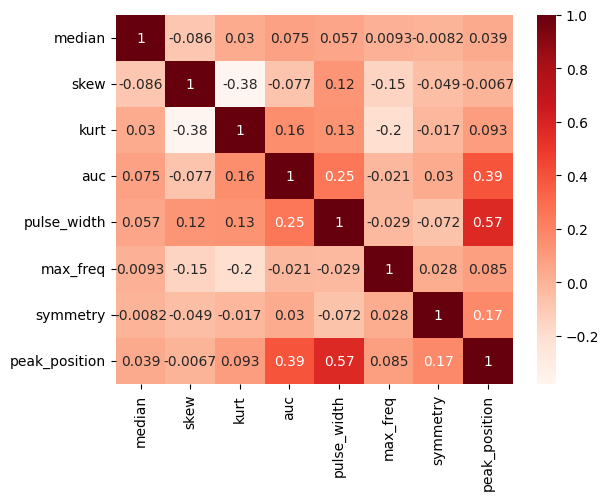

In [329]:
train_features_corr = train_features.corr()
sns.heatmap(train_features_corr, annot=True, cmap=plt.cm.Reds)
plt.show()

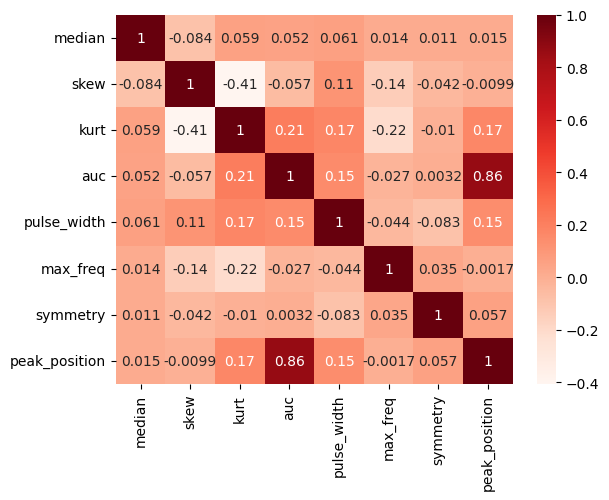

In [330]:
test_features = test_set.__deepcopy__()
test_features.drop(labels=correlated_features, axis=1, inplace=True)
test_features_corr = test_features.corr()
sns.heatmap(test_features_corr, annot=True, cmap=plt.cm.Reds)
plt.show()

*CHANGE IN PERFORMANCE IN BEST AND WORST CLASSIFIER*

Accuracy: 0.8066332916145181


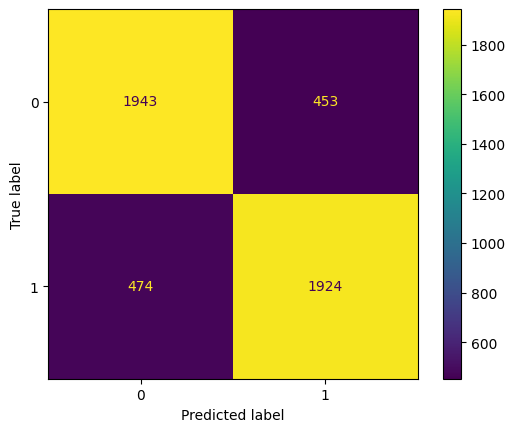

In [331]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit( train_features, train_labels)
pred_labels = model.predict(test_features)

from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labels, pred_labels))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

A bit of a significant change!

Accuracy: 0.6921151439299124


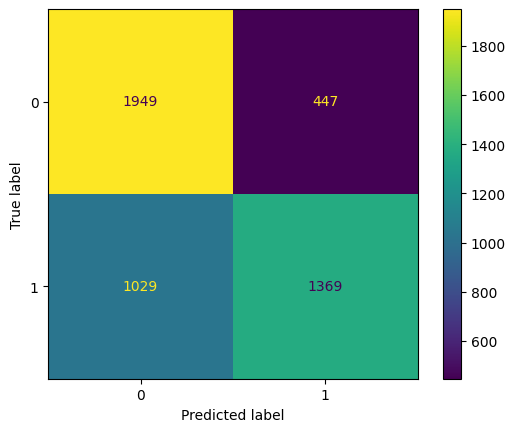

In [332]:
from sklearn import svm

# Create the RFE object and compute a cross-validated score.
model = svm.SVC()
model.fit(train_features, train_labels)
pred_labels = model.predict(test_features)

from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labels, pred_labels))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

SVM: better performance

*GRIDSEARCH FOR HYPERPARAMETER TUNING* (remove chatGPT mention)

Do this on Collab!!

In [340]:
train_set.to_csv('temp_dir/train_set_collab.csv')
test_set.to_csv('temp_dir/test_set_collab.csv')

train_labels_df = pd.DataFrame({'labels':train_labels})
train_labels_df.to_csv('temp_dir/train_labels_collab.csv')
test_labels_df = pd.DataFrame({'labels':test_labels})
test_labels_df.to_csv('temp_dir/test_labels_collab.csv')


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = { #FROM CHATGPT...
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = RandomForestClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)

# Fit the model to the training data
grid_search.fit(train_set, train_labels)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best model
best_model = grid_search.best_estimator_

# Predict using the best model
test_pred = best_model.predict(test_set)

# Evaluate the performance of the best model
accuracy = accuracy_score(test_labels, test_pred)
print(f'Best Hyperparameters: {best_params}')
print(f'Accuracy on Test Set: {accuracy:.2f}')

Did on Colab, no significant change...
Parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Probably need to choose gridpoints less trivially...

Accuracy: 0.820191906549854


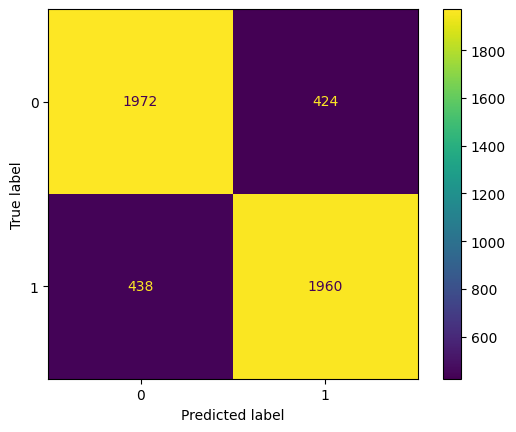

In [342]:
model = RandomForestClassifier(max_depth=None, min_samples_leaf=1,min_samples_split=2,n_estimators= 200)

model.fit(train_set, train_labels)
pred_labels = model.predict(test_set)

from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labels, pred_labels))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
